In [27]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import kagglehub
import seaborn as sns

## Importing the RAVDESS Dataset

In [145]:
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

Path to dataset files: /Users/finnschonknecht/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


In [5]:
rav_path = '/Users/finnschonknecht/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1'

In [7]:
label_map_ravdess = {
    '01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disguist', '08' : 'surprised'
}

In [143]:
ravdess_file_paths = []
ravdess_labels = []

for actor in os.listdir(rav_path):
    actor_path = os.path.join(rav_path, actor)
    for file in os.listdir(actor_path):
        if file.startswith('0'):
            file_path = os.path.join(actor_path, file)
            ravdess_file_paths.append(file_path)
            emotion = file[6:8]
            ravdess_labels.append(label_map_ravdess[emotion])

In [13]:
rav_data = pd.DataFrame({
    'paths' : ravdess_file_paths,
    'emotions' : ravdess_labels
})
## print first 5 rows of data
rav_data.head()

,paths,emotions
0,/Users/finnschonknecht/.cache/kagglehub/datase...,angry
1,/Users/finnschonknecht/.cache/kagglehub/datase...,fearful
2,/Users/finnschonknecht/.cache/kagglehub/datase...,fearful
3,/Users/finnschonknecht/.cache/kagglehub/datase...,angry
4,/Users/finnschonknecht/.cache/kagglehub/datase...,disguist


## Importing the TESS Dataset

In [147]:
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to dataset files:", path)

Path to dataset files: /Users/finnschonknecht/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


In [21]:
tess_path = "/Users/finnschonknecht/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"

In [23]:
tess_file_paths = []
tess_labels = []

for folder in os.listdir(tess_path):
    if folder == 'TESS Toronto emotional speech set data':
        continue
    split = folder.split("_")
    label = split[1:]
    label = ' '.join(label)
    folder_path = os.path.join(tess_path, folder)
    for file in os.listdir(folder_path):
         file_path = os.path.join(folder_path, file)
         tess_file_paths.append(file_path)
         tess_labels.append(label)

In [25]:
tess_data = pd.DataFrame({
    'paths' : tess_file_paths,
    'emotions' : tess_labels
})

tess_data.head()

,paths,emotions
0,/Users/finnschonknecht/.cache/kagglehub/datase...,disgust
1,/Users/finnschonknecht/.cache/kagglehub/datase...,disgust
2,/Users/finnschonknecht/.cache/kagglehub/datase...,disgust
3,/Users/finnschonknecht/.cache/kagglehub/datase...,disgust
4,/Users/finnschonknecht/.cache/kagglehub/datase...,disgust


## Ravdess Label Counts

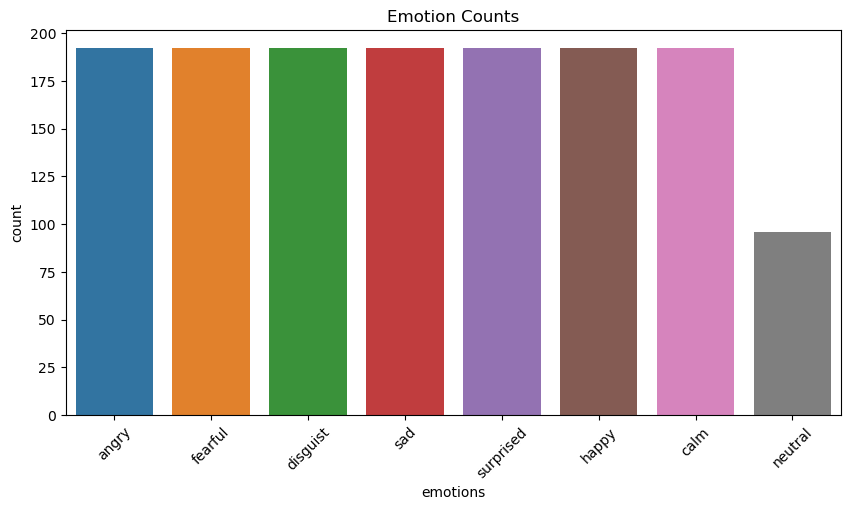

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(x=rav_data['emotions'], order=rav_data['emotions'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Counts")
plt.show()

## TESS Label Counts

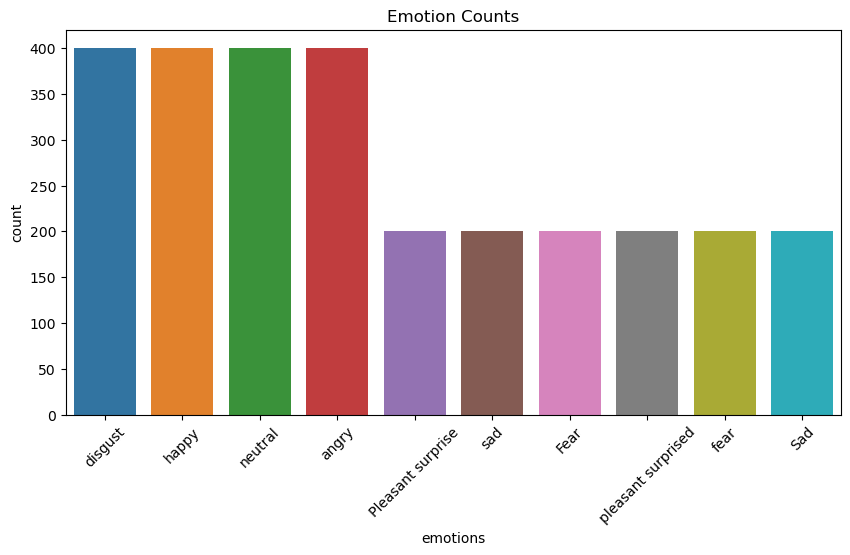

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(x=tess_data['emotions'], order=tess_data['emotions'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Counts")
plt.show()

## Combining the Ravdess and TESS datasets

In [38]:
label_mapping = {
    'Fear': 'fear', 
    'Sad': 'sad',
    'Pleasant surprise': 'pleasant surprised'
}

In [40]:
tess_data['emotions'] = tess_data['emotions'].replace(label_mapping)

In [149]:
all_file_paths = ravdess_file_paths + tess_file_paths 
all_labels = ravdess_labels + tess_labels

emotion_data = pd.DataFrame({
    'paths': all_file_paths,
    'emotions': all_labels
})

print(emotion_data.head())

                                               paths  emotions
0  /Users/finnschonknecht/.cache/kagglehub/datase...     angry
1  /Users/finnschonknecht/.cache/kagglehub/datase...   fearful
2  /Users/finnschonknecht/.cache/kagglehub/datase...   fearful
3  /Users/finnschonknecht/.cache/kagglehub/datase...     angry
4  /Users/finnschonknecht/.cache/kagglehub/datase...  disguist


In [52]:
label_mapping = {
    'disguist': 'disgust', 
    'Fear': 'fear',
    'sad': 'Sad',
    'Pleasant surprise' : 'pleasant surprised'
}

In [54]:
emotion_data['emotions'] = emotion_data['emotions'].replace(label_mapping)

In [56]:
emotion_data['emotions'].unique()

array(['angry', 'fear', 'disgust', 'Sad', 'surprised', 'happy', 'calm',
       'neutral', 'pleasant surprised'], dtype=object)

## Seeing the combined label counts

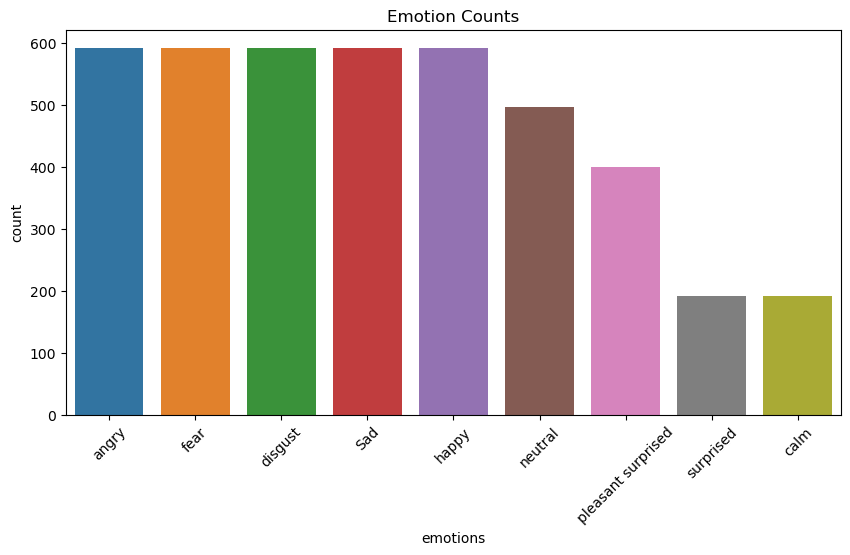

In [58]:
plt.figure(figsize=(10,5))
sns.countplot(x=emotion_data['emotions'], order=emotion_data['emotions'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Counts")
plt.show()

## Extracting MFCC & Chroma features from raw audio

In [311]:
def mfcc(filename):
    y, sr = librosa.load(filename, duration=5, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    return mfcc

In [62]:
def extract_features_from_file(file_path, n_mfcc=13):
    try:
        audio, sr = librosa.load(file_path, sr=None)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)  # Take the mean over time

        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)  # Take the mean over time

        features = np.concatenate((mfcc_mean, chroma_mean))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_audio_dataset(df, feature_column="paths", label_column="emotions", n_mfcc=13):
    features_list = []
    labels_list = []

    for index, row in df.iterrows():
        file_path = row[feature_column]
        label = row[label_column]
        
        # Extract features for the audio file
        features = extract_features_from_file(file_path, n_mfcc=n_mfcc)
        if features is not None:
            features_list.append(features)
            labels_list.append(label)

    features_df = pd.DataFrame(features_list)
    features_df['label'] = labels_list
    return features_df


processed_df = process_audio_dataset(emotion_data)
print("Processed dataset shape:", processed_df.shape)

Processed dataset shape: (4240, 26)


## Training Traditional Models

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import svm

In [69]:
X = processed_df.drop(columns=['label'])
y = processed_df['label'].to_numpy()

In [71]:
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1,1))

encoder.get_feature_names_out()

array(['x0_Sad', 'x0_angry', 'x0_calm', 'x0_disgust', 'x0_fear',
       'x0_happy', 'x0_neutral', 'x0_pleasant surprised', 'x0_surprised'],
      dtype=object)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
sclaler = StandardScaler()

X_train_scaled = sclaler.fit_transform(X_train)
X_test_scaled = sclaler.transform(X_test) 

In [77]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

               Sad       0.80      0.79      0.80       111
             angry       0.82      0.83      0.83       106
              calm       0.53      0.69      0.60        45
           disgust       0.76      0.83      0.79       132
              fear       0.91      0.73      0.81       131
             happy       0.79      0.78      0.79       109
           neutral       0.88      0.86      0.87        94
pleasant surprised       0.96      0.91      0.93        77
         surprised       0.53      0.63      0.57        43

          accuracy                           0.80       848
         macro avg       0.78      0.78      0.78       848
      weighted avg       0.81      0.80      0.80       848



In [85]:
svc = svm.SVC()

svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

               Sad       0.76      0.78      0.77       111
             angry       0.81      0.84      0.82       106
              calm       0.41      0.62      0.50        45
           disgust       0.73      0.78      0.75       132
              fear       0.90      0.73      0.80       131
             happy       0.84      0.79      0.82       109
           neutral       0.99      0.84      0.91        94
pleasant surprised       0.99      0.91      0.95        77
         surprised       0.45      0.58      0.51        43

          accuracy                           0.78       848
         macro avg       0.76      0.76      0.76       848
      weighted avg       0.80      0.78      0.79       848



## Training a LSTM model

In [112]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [106]:
X_train_resampled = X_train_scaled

n_samples = X_train_resampled.shape[0]
n_features = X_train_resampled.shape[1]

time_steps = min(50, n_features) 

if n_features < time_steps:
    raise ValueError("The number of features must be greater than or equal to the number of time steps.")

features_per_time_step = n_features // time_steps

if features_per_time_step == 0:
    raise ValueError(f"Cannot have features per time step = 0. Adjust time_steps or features.")

X_train_reshaped = X_train_resampled.reshape((n_samples, time_steps, features_per_time_step))

print("Reshaped X_train shape:", X_train_reshaped.shape)

Reshaped X_train shape: (3392, 25, 1)


In [108]:
X_test_resampled = X_test_scaled 

n_samples = X_test_resampled.shape[0]
n_features = X_test_resampled.shape[1]

time_steps = min(50, n_features)  

if n_features < time_steps:
    raise ValueError("The number of features must be greater than or equal to the number of time steps.")

features_per_time_step = n_features // time_steps

if features_per_time_step == 0:
    raise ValueError(f"Cannot have features per time step = 0. Adjust time_steps or features.")

X_test_reshaped = X_test_resampled.reshape((n_samples, time_steps, features_per_time_step))
print("Reshaped X_test shape:", X_test_reshaped.shape)

Reshaped X_test shape: (848, 25, 1)


In [110]:
X_train_padded = pad_sequences(X_train_reshaped, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test_reshaped, padding='post', dtype='float32')

In [114]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_test)

y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)

In [120]:
X_train_padded.shape

(3392, 25, 1)

In [126]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(9, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], )
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 25, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 25, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,465 (1.97 MB)

 Trainable params: 515,465 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
history = model.fit(X_train_padded, y_train_one_hot, epochs=25, batch_size=16, validation_data=(X_test_padded, y_val_one_hot))

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3271 - loss: 1.7128 - val_accuracy: 0.3526 - val_loss: 1.6272
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.4285 - loss: 1.4776 - val_accuracy: 0.5401 - val_loss: 1.2332
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5435 - loss: 1.2331 - val_accuracy: 0.6073 - val_loss: 1.1430
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6182 - loss: 1.0645 - val_accuracy: 0.6238 - val_loss: 1.0464
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6360 - loss: 1.0021 - val_accuracy: 0.6462 - val_loss: 0.9807
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6352 - loss: 0.9944 - val_accuracy: 0.6486 - val_loss: 1.0128
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6549 - loss: 0.9326 - val_accuracy: 0.6757 - val_loss: 0.9487
Epoch 8/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6906 - loss: 0.8551 - val_accu

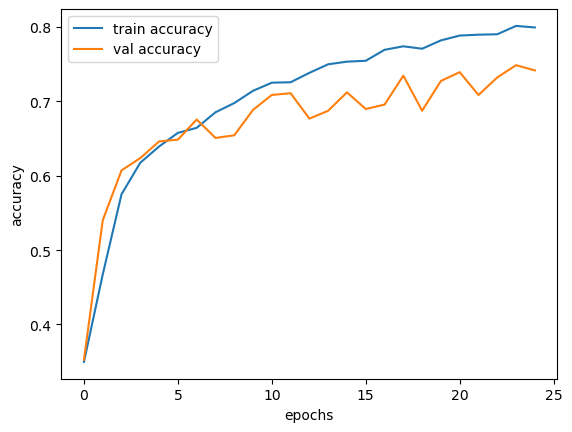

In [132]:
epochs = list(range(25))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [136]:
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Classification Report:
                     precision    recall  f1-score   support

               Sad     0.7565    0.7838    0.7699       111
             angry     0.8091    0.8396    0.8241       106
              calm     0.4118    0.6222    0.4956        45
           disgust     0.7305    0.7803    0.7546       132
              fear     0.8962    0.7252    0.8017       131
             happy     0.8431    0.7890    0.8152       109
           neutral     0.9875    0.8404    0.9080        94
pleasant surprised     0.9859    0.9091    0.9459        77
         surprised     0.4545    0.5814    0.5102        43

          accuracy                         0.7807       848
         macro avg     0.7639    0.7634    0.7584       848
      weighted avg     0.8046    0.7807    0.7886       848

